# HSSM Tutorial

This notebook demonstrates how to use the HSSM class to create hierarchical models. The tutorial will be based on simulated data from the [SSM Simulators (SSMS)](https://github.com/AlexanderFengler/ssms) package.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pytensor

import hssm
import ssms.basic_simulators

pytensor.config.floatX = "float32"

## Simulating a dataset
-  `dataset` passed to the model should always include 'rt' and 'response'.
-  `dataset` should be a pandas dataframe.

In [2]:
# Simulate some data
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]
obs_ddm = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true], model="ddm", n_samples=1000
)
obs_ddm = np.column_stack([obs_ddm["rts"][:, 0], obs_ddm["choices"][:, 0]])
dataset = pd.DataFrame(obs_ddm, columns=["rt", "response"])

dataset

,rt,response
0,4.066924,1.0
1,0.953998,1.0
2,2.666025,1.0
3,3.833941,1.0
4,2.308028,1.0
...,...,...
995,2.887009,-1.0
996,2.931006,1.0
997,2.407033,-1.0
998,1.495991,1.0


## The simplest case
### DDM using the analytical likelihood function from Navarro & Fuss (2009)

#### Analytical model
Simplest usage of HSSM, only data needs to be provided.

In [3]:
simple_ddm_model = hssm.HSSM(data=dataset)
simple_ddm_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ Uniform(lower: -10.0, upper: 10.0)
a ~ HalfNormal(sigma: 2.0)
z ~ Uniform(lower: 0.0, upper: 1.0)	bounds: (0.0, 1.0)
t ~ Uniform(lower: 0.0, upper: 0.5, initval: 0.10000000149011612)

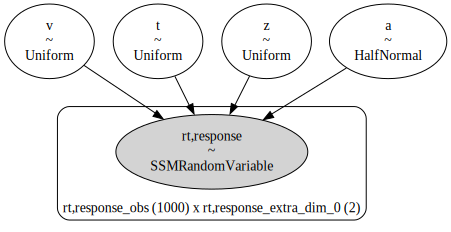

In [4]:
simple_ddm_model.graph()

In [5]:
simple_ddm_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, a, z, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

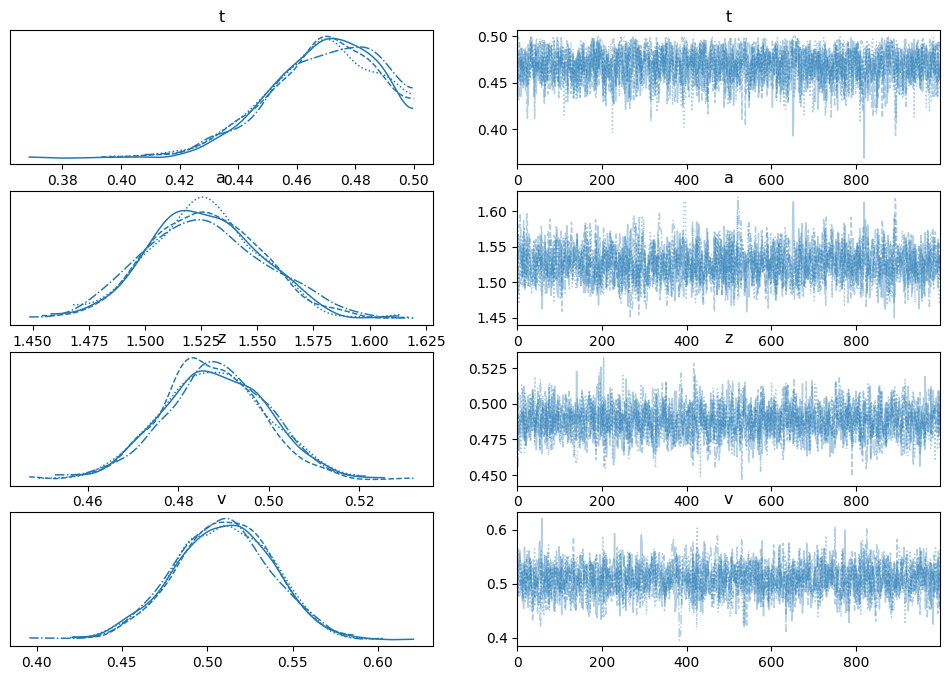

In [6]:
az.plot_trace(simple_ddm_model.traces);

In [7]:
az.summary(simple_ddm_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.469,0.018,0.438,0.500,0.000,0.0,1421.0,1350.0,1.0
a,1.527,0.025,1.479,1.571,0.001,0.0,1650.0,1524.0,1.0
z,0.488,0.011,0.468,0.510,0.000,0.0,1778.0,1971.0,1.0
v,0.509,0.029,0.456,0.563,0.001,0.0,1822.0,2079.0,1.0


## One step up: An angle model using an approximation network

#### Simulating Angle Data

In [8]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs_angle = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
dataset_lan = pd.DataFrame(obs_angle, columns=["rt", "response"])
dataset_lan

,rt,response
0,2.553034,-1.0
1,1.542993,-1.0
2,1.280993,1.0
3,0.925998,-1.0
4,0.716000,1.0
...,...,...
995,1.435992,1.0
996,1.190995,-1.0
997,0.895998,1.0
998,2.664026,1.0


This creates a default angle model using pytensor

In [9]:
angle_model = hssm.HSSM(data=dataset_lan, model="angle")
angle_model

Hierarchical Sequential Sampling Model
Model: angle

Response variable: rt,response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)	bounds: (-3.0, 3.0)
a ~ Uniform(lower: 0.30000001192092896, upper: 3.0)	bounds: (0.3, 3.0)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0010000000474974513, upper: 2.0)	bounds: (0.001, 2.0)
theta ~ Uniform(lower: -0.10000000149011612, upper: 1.2999999523162842)	bounds: (-0.1, 1.3)

In [10]:
pytensor.config.floatX = "float32"

angle_model.sample(cores=1, draws=500, tune=500, mp_ctx="forkserver")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [t, a, theta, z, v]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 55 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

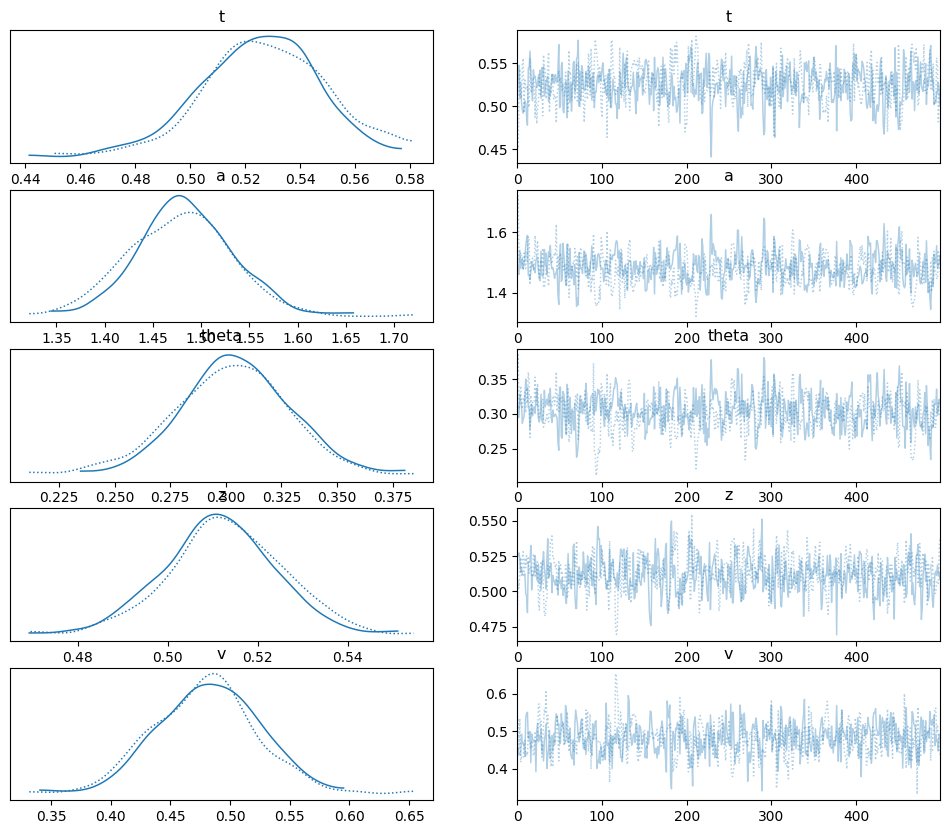

In [11]:
az.plot_trace(angle_model.traces);

#### Sampling the angle model using jax

In [13]:
from jax.config import config

config.update("jax_enable_x64", False)

angle_model.sample(sampler="nuts_numpyro")

Compiling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pymc/sampling/jax.py:641: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:00.684063
Sampling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
sample: 100%|█████████████████████| 2000/2000 [00:34<00:00, 58.33it/s, 31 steps of size 2.02e-01. acc. prob=0.95]
/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(s

Sampling time =  0:02:12.466197
Transforming variables...
Transformation time =  0:00:00.093178


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [14]:
az.summary(angle_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.523,0.023,0.479,0.568,0.001,0.000,1446.0,1522.0,1.0
a,1.488,0.054,1.393,1.596,0.001,0.001,1427.0,1643.0,1.0
theta,0.306,0.026,0.256,0.354,0.001,0.000,1541.0,1867.0,1.0
z,0.513,0.013,0.487,0.536,0.000,0.000,1845.0,1965.0,1.0
v,0.478,0.044,0.399,0.563,0.001,0.001,2031.0,2145.0,1.0


### Using include paramater to use regression and update priors.

#### Case 1: Regression type formula. 

In [15]:
# get some fake simulation data
intercept = 0.3
x = np.random.uniform(0.5, 0.2, size=1000)
y = np.random.uniform(0.4, 0.1, size=1000)

v = intercept + 0.8 * x + 0.3 * y

In [16]:
true_values = np.column_stack(
    [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=1000)]
)
true_values.shape

(1000, 5)

In [17]:
obs_ddm_reg_v = ssms.basic_simulators.simulator(true_values, model="ddm", n_samples=1)
obs_ddm_reg_v

dataset_reg_v = pd.DataFrame(
    {
        "rt": obs_ddm_reg_v["rts"].flatten(),
        "response": obs_ddm_reg_v["choices"].flatten(),
        "x": x,
        "y": y,
    }
)

dataset_reg_v

,rt,response,x,y
0,4.537890,1,0.446542,0.283458
1,2.921007,1,0.377943,0.196293
2,2.272027,1,0.469446,0.257649
3,1.962012,1,0.258155,0.382473
4,1.409992,1,0.457055,0.375368
...,...,...,...,...
995,1.756003,1,0.310187,0.315271
996,3.883937,1,0.268837,0.144753
997,1.514991,1,0.294591,0.251180
998,5.742803,1,0.430607,0.334546


- v is parent
- x is a feature from the dataset_reg_v
- y is a feature from the dataset_reg_v

In [18]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.0, "upper": 0.5},
                "x": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)
model_reg_v

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ 1 + x + y
	Link: identity
	Intercept ~ Uniform(lower: 0.0, upper: 0.5)
	x ~ Uniform(lower: 0.0, upper: 1.0)
	y ~ Uniform(lower: 0.0, upper: 1.0)
a ~ HalfNormal(sigma: 2.0)
z ~ Uniform(lower: 0.0, upper: 1.0)	bounds: (0.0, 1.0)
t ~ Uniform(lower: 0.0, upper: 0.5, initval: 0.10000000149011612)

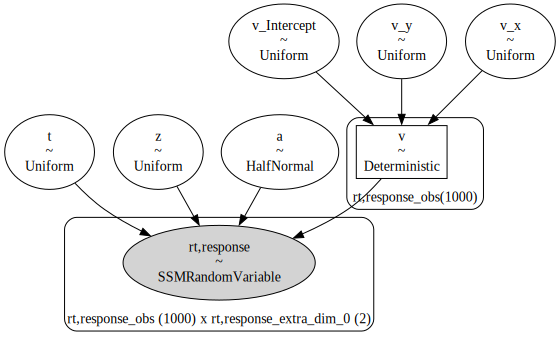

In [19]:
model_reg_v.graph()

In [20]:
trace_reg_v = model_reg_v.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, a, z, v_Intercept, v_x, v_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


array([[<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'v_Intercept'}>],
       [<Axes: title={'center': 'v_x'}>, <Axes: title={'center': 'v_x'}>],
       [<Axes: title={'center': 'v_y'}>, <Axes: title={'center': 'v_y'}>]],
      dtype=object)

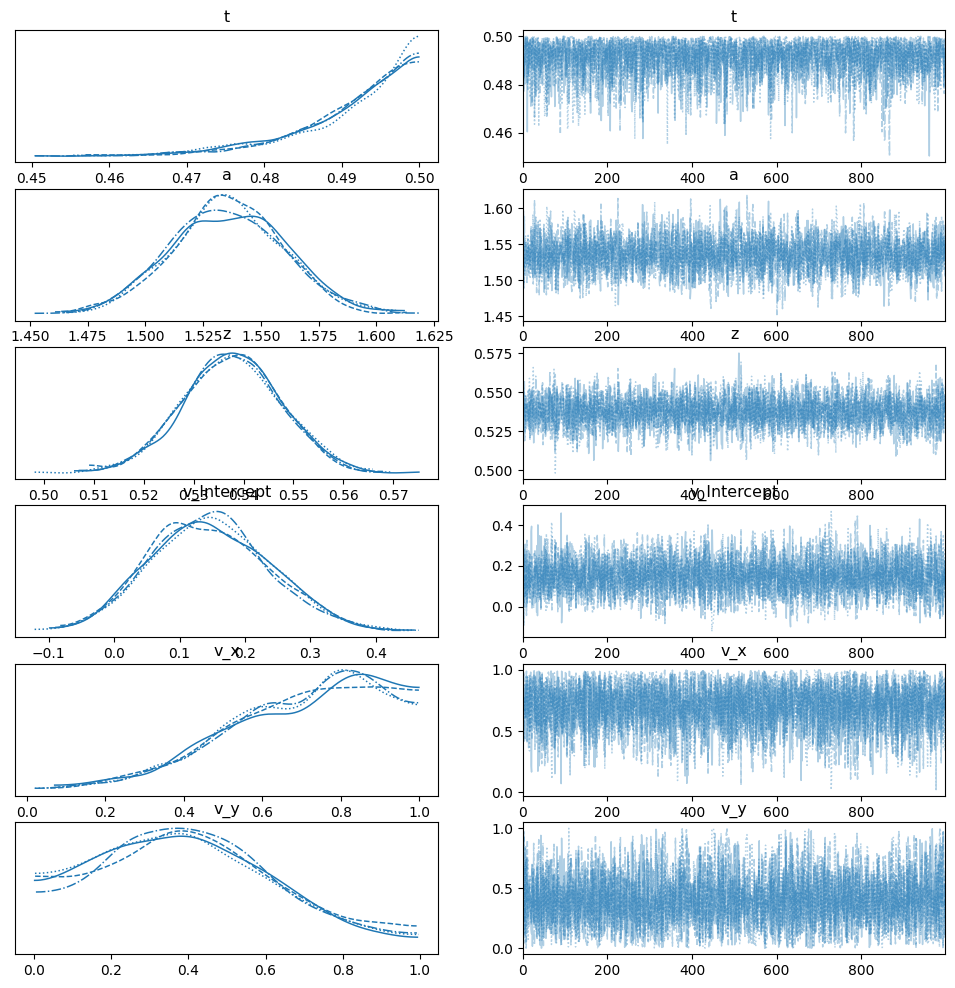

In [21]:
az.plot_trace(model_reg_v.traces)

In [22]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.491,0.008,0.477,0.500,0.000,0.000,2968.0,2097.0,1.0
a,1.536,0.024,1.492,1.583,0.000,0.000,3436.0,2789.0,1.0
z,0.538,0.010,0.520,0.556,0.000,0.000,4190.0,3044.0,1.0
v_Intercept,0.147,0.090,-0.017,0.316,0.001,0.001,4534.0,2951.0,1.0
v_x,0.704,0.194,0.366,1.000,0.003,0.002,4177.0,2056.0,1.0
v_y,0.399,0.224,0.000,0.781,0.003,0.003,3768.0,2048.0,1.0


#### Case 2: adding initval to priors along with lower and upper.

- v is a parent
- x is a feature from the dataset_reg_v

Adding initval is optional.

In [23]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 1.0,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "v ~ 1 + x",
        }
    ],
)

In [24]:
hssm_include_val

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ 1 + x
	Link: identity
	Intercept ~ Uniform(lower: -3.0, upper: 3.0, initval: 1.0)
	x ~ Uniform(lower: -0.5, upper: 0.5, initval: 0.0)
a ~ HalfNormal(sigma: 2.0)
z ~ Uniform(lower: 0.0, upper: 1.0)	bounds: (0.0, 1.0)
t ~ Uniform(lower: 0.0, upper: 0.5, initval: 0.10000000149011612)

In [25]:
samples_two = hssm_include_val.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, a, z, v_Intercept, v_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [26]:
az.summary(samples_two)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.481,0.014,0.456,0.500,0.000,0.000,1898.0,1610.0,1.0
a,1.551,0.026,1.502,1.602,0.001,0.000,2436.0,2162.0,1.0
z,0.504,0.012,0.479,0.525,0.000,0.000,2169.0,2093.0,1.0
v_Intercept,0.517,0.050,0.429,0.610,0.001,0.001,3140.0,2904.0,1.0
v_x,0.374,0.112,0.161,0.500,0.002,0.001,3035.0,2107.0,1.0


#### Case 3: not specifying parent v in the include parameter. 

The parent is v by default, specifying it is not mandatory. 

In [27]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "a",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": 0.0,
                    "upper": 1.0,
                    "initval": 0.5,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "a ~ 1 + x",
        }
    ],
)

In [28]:
hssm_include_val

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

a ~ 1 + x
	Link: identity
	Intercept ~ Uniform(lower: 0.0, upper: 1.0, initval: 0.5)
	x ~ Uniform(lower: -0.5, upper: 0.5, initval: 0.0)
v ~ Uniform(lower: -10.0, upper: 10.0)
z ~ Uniform(lower: 0.0, upper: 1.0)	bounds: (0.0, 1.0)
t ~ Uniform(lower: 0.0, upper: 0.5, initval: 0.10000000149011612)

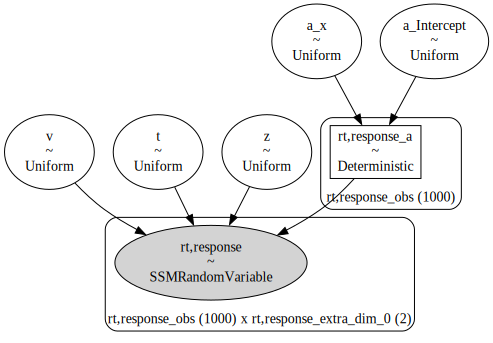

In [29]:
hssm_include_val.graph()

In [30]:
samples_three = hssm_include_val.sample(draws=500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, z, v, a_Intercept, a_x]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


In [31]:
az.summary(samples_three)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.499,0.001,0.497,0.500,0.000,0.000,1622.0,1122.0,1.0
z,0.452,0.011,0.431,0.474,0.000,0.000,1470.0,1346.0,1.0
v,0.478,0.027,0.430,0.529,0.001,0.000,1599.0,1398.0,1.0
a_Intercept,1.038,0.038,0.965,1.108,0.001,0.001,1696.0,914.0,1.0
a_x,-0.108,0.108,-0.309,0.096,0.003,0.003,1691.0,914.0,1.0
...,...,...,...,...,...,...,...,...,...
"rt,response_a[995]",1.004,0.004,0.996,1.012,0.000,0.000,1731.0,952.0,1.0
"rt,response_a[996]",1.008,0.009,0.992,1.025,0.000,0.000,1708.0,943.0,1.0
"rt,response_a[997]",1.006,0.006,0.994,1.017,0.000,0.000,1718.0,971.0,1.0
"rt,response_a[998]",0.991,0.009,0.975,1.008,0.000,0.000,1676.0,961.0,1.0


#### Case 4, including multiple dictionaries in the include parameter. Creating hierarchical model. 

In [32]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "v ~ 1 + x + y",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "a ~ 1 + x + y",
        },
    ],
)

In [33]:
hssm_include_list.model

       Formula: c(rt, response) ~ 1 + x + y
                a ~ 1 + x + y
        Family: analytical
          Link: v = identity
                a = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Uniform(lower: -2.0, upper: 3.0)
            x ~ Uniform(lower: -0.5, upper: 0.5)
            y ~ Uniform(lower: -0.5, upper: 0.5)
        
        Auxiliary parameters
            c(rt, response)_t ~ Uniform(lower: 0.0, upper: 0.5, initval: 0.10000000149011612)
            c(rt, response)_z ~ Uniform(lower: 0.0, upper: 1.0)
    target = a
        Common-level effects
            a_Intercept ~ Uniform(lower: -2.0, upper: 3.0)
            a_x ~ Uniform(lower: -0.5, upper: 0.5)
            a_y ~ Uniform(lower: -0.5, upper: 0.5)

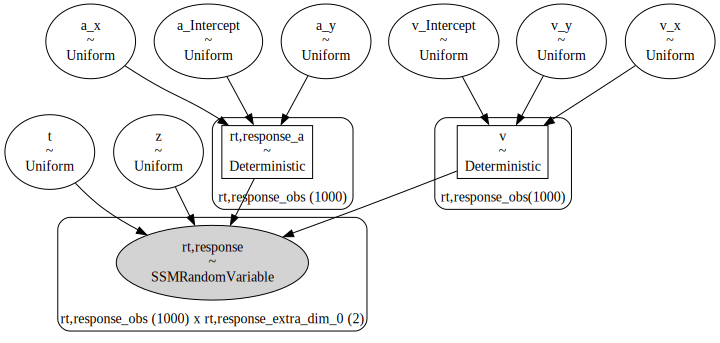

In [34]:
hssm_include_list.graph()

In [35]:
samples_two = hssm_include_list.sample(draws=100, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, z, v_Intercept, v_x, v_y, a_Intercept, a_x, a_y]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 19 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### Case 5. including multiple dictionaries in the include parameter. Specifying prior as a float number. 

In [36]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
        },
        {"name": "a", "prior": 0.5},
    ],
)

In [37]:
samples_three = hssm_include_list.sample(draws=100, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, z, v_Intercept, v_x, v_y]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
